Cleaning and Filtering the Master Data File

In [90]:
# Import libraries:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
# Graph output styling from matplotlib:
plt.style.use('fivethirtyeight')
# plt.style.use('dark_background')

In [91]:
# Global variables:
repo_dir = os.getcwd()  # Directory of the notebook
source_data_dir = os.path.join(repo_dir, 'fbref-dw-merges')

# League ID and name mapping variables:
league_ids = ['ENG-Premier League', 'ESP-La Liga', 'FRA-Ligue 1', 'ITA-Serie A']
league_names = ['Premier League', 'La Liga', 'Ligue 1', 'Serie A']
league_names_dict = dict(zip(league_ids, league_names))

# Big teams list:
big_teams = ['Arsenal', 'Manchester City', 'Manchester Utd', 'Tottenham', 'Chelsea', 'Liverpool', 'Real Madrid', 'Barcelona', 'Atlético Madrid', 'Paris S-G', 'Juventus', 'Milan', 'Inter']

# Playing time duplicate columns (to be removed from the master file):
playing_time_duplicates = ['Min.1', 'Mn/MP', 'Min%', '90s', 'Starts.1', 'Mn/Start', 'Compl', 'Subs', 'Mn/Sub', 'unSub']

In [92]:
# Function that writes the output data to a CSV file:
def make_csv(dir, df, file_name):
    file_path = os.path.join(dir, f'{file_name}.csv')
    return df.to_csv(file_path)


# Function that removes unnamed columns:
def remove_unnamed_cols(df):

    # Create list of unnamed columns:
    columns = df.columns
    unnamed_cols = [col for col in columns if "Unnamed" in col]

    # Create a new df:
    new_df = (df
              .drop(columns=unnamed_cols)
              )

    return new_df


# Function that removes YOB column so that age can be standardized later:
def remove_YOB_col(df):
    return (df.drop(columns='YOB'))


# Function that removes unnecessary DW player/team ID columns:
def remove_dw_info(df):
    return (df.drop(columns=['team_id', 'player_id', 'league_id']))


# Function that removes duplicate FBref playing time columns:
def remove_playing_time_cols(df):
    return (df.drop(columns=playing_time_duplicates))


# Function that slices the master file based on an optimal playing time cutoff:
def playing_time_slice(df, cutoff : int = 8):
    return (df[df['90s_r'] >= cutoff]
            .reset_index()
            .drop(columns='index')
            )


# Function that adds the log(market value) column to the data:
def add_log_mkt_val_col(df):
    df['log_mkt_val'] = np.log(df['market_value_in_eur'])
    return df


# Function that adds the "Big Team" dummy variable to the data:
def add_big_team_col(df):
    df['Big Team'] = df['team'].isin(big_teams).astype(int)
    return df


# Function that adds a clean league name column based on league id:
def add_league_name_col(df):
    df['league_name'] = df['league'].map(league_names_dict)
    return df

In [93]:
# Import the master file and make a copy:
master_df = pd.read_csv(os.path.join(source_data_dir, 'master_file.csv'))
master_df_copy = master_df.copy(deep=True)
# master_df_copy

Analyze matches played, 90s, and minutes played to select a cutoff point:

In [ ]:
# Generate histogram/KDE plots for the playing time variables:
playing_time_cols = ['Starts', 'Min', '90s_r']
for col in playing_time_cols:
    plt.figure(figsize=(9,5))
    sns.histplot(data=master_df_copy, x=col, kde=True)
    plt.title(f'{col} KDE Plot')
    if col == 'Min':
        plt.axvline(x=720, color='r', linestyle='--')
        plt.show()
    elif col == '90s_r':
        plt.axvline(x=8, color='r', linestyle='--')
        plt.show()
    else:
        plt.axvline(x=10, color='r', linestyle='--')
        plt.show()

In [ ]:
# Test the proposed playing time cutoff measures:
playing_time_dict = {'Starts' : 10, 'Min' : 720, '90s_r' : 8} # use this to alter the playing time metric cutoffs if necessary
for key, val in playing_time_dict.items():

    # Slice the master file by the cutoff value:
    cut_df = master_df_copy[master_df_copy[key] >= val]
    
    # Compute and print the data loss (as a % of the original row total):
    data_loss = ((7121 - cut_df.shape[0]) / 7121)*100
    print(f'\nData Loss from the {key} Column Cutoff: {data_loss:.2f}%')

### CONCLUSION: WILL USE THE 90s_r >= 8 cutoff since it's associated with the least amount of data loss ###

Test temporary cleaning/slicing measures:

In [94]:
cleaned_master_df = remove_unnamed_cols(master_df_copy)
cleaned_master_df = remove_YOB_col(cleaned_master_df)
cleaned_master_df = remove_dw_info(cleaned_master_df)
cleaned_master_df = remove_playing_time_cols(cleaned_master_df)
cleaned_master_df = playing_time_slice(cleaned_master_df)
# cleaned_master_df

Add the necessary columns to the cleaned master file:

In [ ]:
# cleaned_master_df = add_big_team_col(cleaned_master_df)
# cleaned_master_df = add_league_name_col(cleaned_master_df)
# cleaned_master_df = add_log_mkt_val_col(cleaned_master_df)
# cleaned_master_df

Fit Dummy Variables to Covariates, Other Columns:

In [95]:
# Iterate the get_dummies() process over the variables of interest:
# dummy_cols = ['league_name', 'team', 'season', 'nationality', 'position']
dummy_cols = ['team', 'season', 'nationality', 'position'] # removed the league name variable for PCA prep

# Initialize the list of dataframes for concatenation, starting with the clean master file:
dfs_to_concat = [cleaned_master_df]

for col in dummy_cols:

    # Create the dummy variable dataframe:
    dummy_df = pd.get_dummies(cleaned_master_df[col], drop_first=False)

    # Add it to the list of dataframes to concat:
    dfs_to_concat.append(dummy_df)

# Concatenate the dataframes:
cleaned_master_with_dummies_df = pd.concat(dfs_to_concat, axis=1)
cleaned_master_with_dummies_df


,league,season,team,player_name,nationality,position,age,MP,Starts,Min,...,DF,"DF,FW","DF,MF",FW,"FW,DF","FW,MF",GK,MF,"MF,DF","MF,FW"
0,ENG-Premier League,1718,Liverpool,Alex Oxlade-Chamberlain,ENG,"MF,FW",23.0,32.0,14.0,1493.0,...,0,0,0,0,0,0,0,0,0,1
1,ENG-Premier League,1718,Arsenal,Granit Xhaka,SUI,MF,24.0,38.0,37.0,3260.0,...,0,0,0,0,0,0,0,1,0,0
2,ENG-Premier League,1718,Arsenal,Mohamed Elneny,EGY,MF,25.0,13.0,11.0,867.0,...,0,0,0,0,0,0,0,1,0,0
3,ENG-Premier League,1718,Arsenal,Rob Holding,ENG,DF,21.0,12.0,9.0,822.0,...,1,0,0,0,0,0,0,0,0,0
4,ENG-Premier League,1718,Bournemouth,Adam Smith,ENG,"DF,MF",26.0,27.0,22.0,2071.0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4910,ITA-Serie A,2223,Udinese,Nehuén Pérez,ARG,DF,22.0,34.0,33.0,2818.0,...,1,0,0,0,0,0,0,0,0,0
4911,ITA-Serie A,2223,Udinese,Roberto Pereyra,ARG,"DF,MF",31.0,34.0,33.0,2820.0,...,0,0,1,0,0,0,0,0,0,0
4912,ITA-Serie A,2223,Udinese,Rodrigo Becão,BRA,DF,26.0,28.0,28.0,2484.0,...,1,0,0,0,0,0,0,0,0,0
4913,ITA-Serie A,2223,Udinese,Tolgay Arslan,GER,MF,31.0,36.0,12.0,1211.0,...,0,0,0,0,0,0,0,1,0,0


In [ ]:
# Determine number of dummy variable categories for dimension verification:

# cleaned_master_df['nationality'].unique()
nationality_list = ['ENG', 'SUI', 'EGY', 'ISR', 'ITA', 'CMR', 'GER', 'IRL', 'SCO',
       'WAL', 'ESP', 'FRA', 'BEL', 'GHA', 'ARG', 'CIV', 'SEN', 'USA',
       'COD', 'AUT', 'NGA', 'ALG', 'JAM', 'BRA', 'NED', 'POR', 'ECU',
       'SWE', 'SVK', 'COL', 'KEN', 'PER', 'URU', 'NIR', 'NZL', 'POL',
       'ROU', 'CAN', 'GUA', 'PHI', 'SRB', 'DEN', 'GUI', 'PAR', 'NOR',
       'MEX', 'ZIM', 'CUB', 'FIN', 'GRE', 'MLI', 'UKR', 'BFA', 'MAR',
       'ANG', 'SKN', 'GAB', 'JPN', 'GRN', 'ZAM', 'VEN', 'AUS', 'CRC',
       'SVN', 'CHI', 'TOG', 'RUS', 'CPV', 'MKD', 'CRO', 'CTA', 'TUR',
       'HON', 'EQG', 'nan', 'MOZ', 'ARM', 'ALB', 'KVX', 'MNE', 'GEO', 'GNB',
       'MTN', 'BEN', 'CGO', 'HAI', 'TUN', 'RSA', 'LUX', 'MTQ', 'GLP',
       'COM', 'NCL', 'NIG', 'TRI', 'GUF', 'MAD', 'LBY', 'CZE', 'HUN',
       'EST', 'GAM', 'BIH', 'CYP', 'BUL', 'SUR', 'SLE', 'UZB']
# len(nationality_list)
# this length was equal to 108

# cleaned_master_df['team'].unique()

team_list = ['Liverpool', 'Arsenal', 'Bournemouth', 'Brighton', 'Burnley',
       'Everton', 'Chelsea', 'Crystal Palace', 'Huddersfield',
       'Leicester City', 'Southampton', 'Manchester City',
       'Manchester Utd', 'Newcastle Utd', 'Stoke City', 'Swansea City',
       'Tottenham', 'Watford', 'West Brom', 'West Ham', 'Cardiff City',
       'Fulham', 'Wolves', 'Aston Villa', 'Norwich City', 'Sheffield Utd',
       'Leeds United', 'Brentford', "Nott'ham Forest", 'Alavés',
       'Athletic Club', 'Real Sociedad', 'Leganés', 'Atlético Madrid',
       'Barcelona', 'Betis', 'Celta Vigo', 'Eibar', 'Espanyol', 'Getafe',
       'Málaga', 'Girona', 'La Coruña', 'Las Palmas', 'Levante',
       'Real Madrid', 'Sevilla', 'Valencia', 'Villarreal', 'Huesca',
       'Rayo Vallecano', 'Valladolid', 'Osasuna', 'Granada', 'Mallorca',
       'Cádiz', 'Elche', 'Almería', 'Amiens', 'Angers', 'Bordeaux',
       'Caen', 'Dijon', 'Guingamp', 'Lille', 'Lyon', 'Marseille', 'Metz',
       'Monaco', 'Paris S-G', 'Montpellier', 'Nantes', 'Nice', 'Rennes',
       'Saint-Étienne', 'Strasbourg', 'Toulouse', 'Troyes', 'Nîmes',
       'Reims', 'Brest', 'Lens', 'Lorient', 'Clermont Foot', 'Ajaccio',
       'Auxerre', 'Atalanta', 'Benevento', 'Sampdoria', 'Bologna',
       'Cagliari', 'Crotone', 'Chievo', 'Fiorentina', 'Sassuolo', 'Genoa',
       'Hellas Verona', 'Torino', 'Inter', 'Juventus', 'Lazio', 'Milan',
       'Napoli', 'Roma', 'SPAL', 'Udinese', 'Frosinone', 'Empoli',
       'Parma', 'Lecce', 'Brescia', 'Spezia', 'Salernitana', 'Venezia',
       'Cremonese', 'Monza']
# len(team_list)
# this length was equal to 116

cleaned_master_df['position'].unique()
all_positions = ['MF,FW', 'MF', 'DF', 'DF,MF', 'FW', 'FW,MF', 'GK', 'MF,DF',
       'FW,DF', 'DF,FW']
# len(all_positions)
# this length was equal to 10

In [96]:
# Remove all NaN values from the data:
final_master_df = cleaned_master_with_dummies_df.dropna().reset_index().drop(columns='index')
final_master_df

,league,season,team,player_name,nationality,position,age,MP,Starts,Min,...,DF,"DF,FW","DF,MF",FW,"FW,DF","FW,MF",GK,MF,"MF,DF","MF,FW"
0,ENG-Premier League,1718,Liverpool,Alex Oxlade-Chamberlain,ENG,"MF,FW",23.0,32.0,14.0,1493.0,...,0,0,0,0,0,0,0,0,0,1
1,ENG-Premier League,1718,Arsenal,Granit Xhaka,SUI,MF,24.0,38.0,37.0,3260.0,...,0,0,0,0,0,0,0,1,0,0
2,ENG-Premier League,1718,Arsenal,Mohamed Elneny,EGY,MF,25.0,13.0,11.0,867.0,...,0,0,0,0,0,0,0,1,0,0
3,ENG-Premier League,1718,Bournemouth,Adam Smith,ENG,"DF,MF",26.0,27.0,22.0,2071.0,...,0,0,1,0,0,0,0,0,0,0
4,ENG-Premier League,1718,Bournemouth,Andrew Surman,ENG,MF,30.0,25.0,20.0,1856.0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4137,ITA-Serie A,2223,Udinese,Nehuén Pérez,ARG,DF,22.0,34.0,33.0,2818.0,...,1,0,0,0,0,0,0,0,0,0
4138,ITA-Serie A,2223,Udinese,Roberto Pereyra,ARG,"DF,MF",31.0,34.0,33.0,2820.0,...,0,0,1,0,0,0,0,0,0,0
4139,ITA-Serie A,2223,Udinese,Rodrigo Becão,BRA,DF,26.0,28.0,28.0,2484.0,...,1,0,0,0,0,0,0,0,0,0
4140,ITA-Serie A,2223,Udinese,Tolgay Arslan,GER,MF,31.0,36.0,12.0,1211.0,...,0,0,0,0,0,0,0,1,0,0


Standardize Quantitative Data for the Principle Component Analysis (PCA):

In [ ]:
# Print cleaned dataframe column datatypes to ensure they are all at least floats:
print('Index')
for index, column in enumerate(final_master_df.columns):
    print(f"{index}\t{column}: {final_master_df[column].dtype}")

# NOTE: THE NON-QUANT VARIABLES LIKE PLAYER NAME AND LEAGUE ARE STORE AS 'OBJECT' DTYPES, AS OPPOSED TO STRINGS, IDK WHY 

# Determine the appropriate column range for standardization: columns [0:5] don't need to be standardized
# Columns [6:145] need to be standardized
# Columns [146:] do not need to be standardized, they are dummies

In [115]:
# Attempt to normalize the dataframe using scikitlearn:
from sklearn.preprocessing import StandardScaler

# Initialize StandardScaler:
scaler = StandardScaler()

# Data to standardize:
data_to_scale = final_master_df.iloc[:, 6:146].values

# Fit and transform the selected columns:
scaled_data = scaler.fit_transform(data_to_scale)

# Create a DataFrame from the scaled data:
scaled_df = pd.DataFrame(scaled_data, columns=final_master_df.columns[6:146])

# # Send standardized master file to a CSV in the source directory:
# make_csv(source_data_dir, master_df_scaled, 'master_file_standardized')

In [ ]:
# Understand key variable distributions before conducting analysis:
key_vars = scaled_df.columns

# Plot kernel density for the features:
for key_var in key_vars:
    sns.kdeplot(data=scaled_df, x=key_var)
    plt.title(f'KDE of {key_var}')
    plt.show()

# NOTE: the distributions of most of the features, along with the standardized target variable (market value), are RIGHT-SKEWED. 
# This should influence the models that are built on PCA components and the key feature models that I build as a baseline
# Mitigations: to mitigate skewness bias, use MAPE and MedAE as error metrics along with the basic ones; consider ensemble methods in modeling (like bagged trees), use CV in model selection/parameter tuning 

PCA Workflow:

In [116]:
# Test-train split of the standardized dataframe:
from sklearn.model_selection import train_test_split

# Start by using LN(Market Value) as the target variable:
y = scaled_df['market_value_in_eur'] # using the actual value, not the natural log
X = scaled_df.drop(columns='market_value_in_eur') # everything but the target variable
# Convert all feature column names to strings for PCA fitting:
X.columns = X.columns.astype(str)

# Conduct the test-train split:
seed_value = 42
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed_value)

In [117]:
# Try to fit a PCA on the training data:
from sklearn.decomposition import PCA

# Create an instance of the PCA model:
pca = PCA(0.95) # "minimum number of components such that 95% of the variance is retained" - Medium tutorial

# Fit the model on the training features:
pca.fit(X_train)

PCA(n_components=0.95)

Explained Variance Ratio: [0.2755425  0.22968703 0.06948569 0.05400471 0.04115906 0.02555977
 0.025126   0.02200784 0.01903574 0.01581777 0.01354242 0.01103213
 0.01048564 0.01013378 0.00898702 0.00868076 0.00839918 0.0077749
 0.00719581 0.00686753 0.00657062 0.0062193  0.00608006 0.00586535
 0.00546971 0.00508559 0.00481748 0.00463061 0.00433846 0.00419922
 0.00409303 0.0037099  0.00349595 0.00345153 0.00323073 0.00305764
 0.00298516 0.00286911]


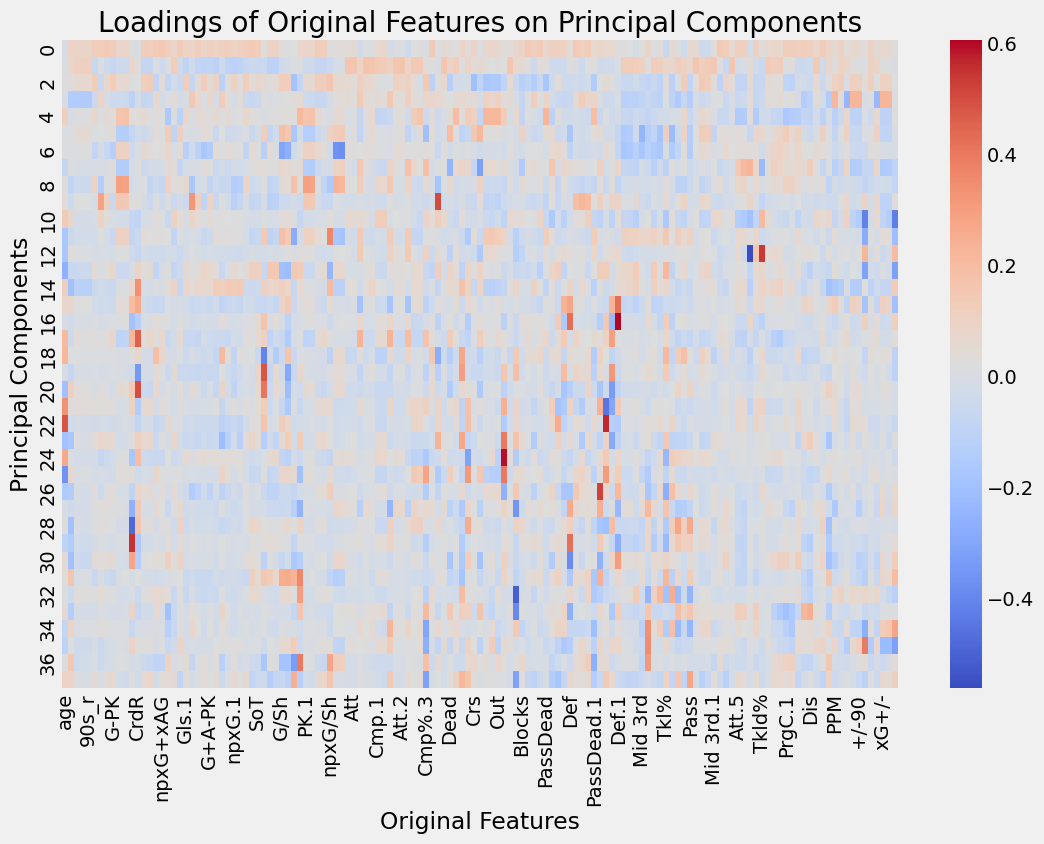

In [118]:
# Check the explained variance ratio:
# print("Explained Variance Ratio:", pca.explained_variance_ratio_)

# Print the component-feature correlation matrix (optional):
pca_components_df = pd.DataFrame(pca.components_, columns=X_train.columns)
# pca_components_df #.head()

# Plot a heatmap of the PCA components and original features:
plt.figure(figsize=(12, 8))
sns.heatmap(pca_components_df, cmap='coolwarm', fmt=".2f") #annot=True, 
plt.title('Loadings of Original Features on Principal Components')
plt.xlabel('Original Features')
plt.ylabel('Principal Components')
plt.show()

In [119]:
# Transform the training and testing features using the learned transformation:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
# X_train_pca

In [120]:
# Fit an OLS model on the training PCA data:
import statsmodels.api as sm

# Concatenate the principle components (test and train) with a constant:
X_train_pca_with_constant = sm.add_constant(X_train_pca)
X_test_pca_with_constant = sm.add_constant(X_test_pca)

# Fit the OLS model:
train_ols_model = sm.OLS(y_train, X_train_pca_with_constant) # Y from training data principle components from training data
train_ols_results = train_ols_model.fit()

# Regression Output:
print(train_ols_results.summary())

                             OLS Regression Results                            
Dep. Variable:     market_value_in_eur   R-squared:                       0.585
Model:                             OLS   Adj. R-squared:                  0.581
Method:                  Least Squares   F-statistic:                     121.7
Date:                 Tue, 16 Apr 2024   Prob (F-statistic):               0.00
Time:                         11:33:54   Log-Likelihood:                -3175.7
No. Observations:                 3313   AIC:                             6429.
Df Residuals:                     3274   BIC:                             6668.
Df Model:                           38                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0020      0.011     -0.17

In [121]:
# Use the OLS model to predict the training data:
ols_test_pred = train_ols_results.predict(X_test_pca_with_constant)

# Errors:
from sklearn.metrics import mean_absolute_error, mean_squared_error
ols_mae = mean_absolute_error(y_test, ols_test_pred)
ols_mse = mean_squared_error(y_test, ols_test_pred)
ols_rmse = np.sqrt(ols_mse)
ols_errors = [ols_mae, ols_mse, ols_rmse]

for var, name in zip(ols_errors, ['MAE', 'MSE', 'RMSE']):
    print(f'\nOLS with PCA Component Predictors - {name}: {var:.4f}')



OLS with PCA Component Predictors - MAE: 0.4446

OLS with PCA Component Predictors - MSE: 0.4777

OLS with PCA Component Predictors - RMSE: 0.6912


Fit PCA Models for Position-Specific Dataframes: